In [1]:
import os
import sys

# Ensure the repository root is on sys.path when executed from tests/types.
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.types import Array, Index, Series, SeriesMatrix
from gwexpy.types.metadata import MetaData, MetaDataDict, MetaDataMatrix
# from gwexpy.timeseries import TimeSeries, TimeSeriesDict, TimeSeriesMatrix
# from gwexpy.frequencyseries import FrequencySeries, FrequencySeriesMatrix


# 初期化関数
* 0D data(スカラー) 入力　（int, float, complex, Quantity）
  * shape = (1, 1, N_samples) 行列
  * xindex によりサンプリング軸方向に定数列としてブロードキャスト
  * Quantityの場合は単位も引き継ぐ
* 1D data 入力（Quantity, Array, Series, list, np.ndarray (1D)）
  * shape = (1, 1, N_samples) 行列
  * Quantity, Array, Seriesからは単位等も引き継ぐ
  * Seriesからは単位も引き継ぐ
* 2D行列入力　(list, np.ndarray (2D), Quantity(2D)）
  * shape = (N_row, N_col, N_samples) 行列
  * xindex によりサンプリング軸方向に定数列としてブロードキャスト
  * Quantityの場合は単位も引き継ぐ
* 1D オブジェクト（Quantity, Array, Series, list, np.ndarray (1D)） の 1D/2D行列　(list, dict, ...）
  * shape = (N_row, N_col, N_samples) 行列
  * それぞれの1D データを 行列要素とする
  * 基本的にすべての1D オブジェクトは同じサンプリング(xindex)である必要がある
  * 例外的に、スカラー (0D　オブジェクト)要素がある場合は定数列としてブロードキャスト
  * 要素がQuantity, Array, Seriesの場合は単位等も引き継ぐ
* 3D np.ndarray, Quantity（直接構築）
  * 同じshapeの  SeriesMatrixにする
  * unitsなどの行列成分メタデータ、xunitなどを追加可能
 
# 演算
 1. selfからshape, xindex, MetaDataMatrix, その他の情報(rows, cols, epochなど)を取得
 2. self以外の項の  shape, xindex, MetaDataMatrix (units) を確認
 3. 和・差・比較の場合は、単位が整合していることを確認
 4. SeriesMatrix, 3D array/Quantityの場合はshapeが一致することを確認 
 5. スカラー、array/Quantityの場合は __new__ 関数でSeriesMatrixオブジェクトに変換
 6. inputsリストに格納
 7. 演算処理

In [2]:
print("=== SeriesMatrix メタデータ構築テスト ===")

# 共通の xindex
ix = Index(np.linspace(0, 1, 5), unit="s")

# ケース 1: 単位/名前/チャネルを明示的に与える
data = np.random.randn(2, 2, 5)
units = [[u.m, u.s], [u.kg, u.N]]
names = [["x", "y"], ["m", "F"]]
channels = [[None, None], ["CH1", "CH2"]]

sm = SeriesMatrix(data, xindex=ix, units=units, names=names, channels=channels)
print("構築成功")
print("単位:", sm["row0", "col0"].unit)
print("名前:", sm["row1", "col1"].name)
print("チャネル:", sm["row1", "col1"].channel)

# ケース 2: Series が含まれ、かつ units も与えられた → エラーを期待
try:
    s1 = Series(np.ones(5), xindex=ix, unit="m", name="x")
    s2 = Series(np.zeros(5), xindex=ix, unit="s", name="y")
    SeriesMatrix([[s1, s2]], units=[[u.s, u.s]])
except ValueError as e:
    print("エラー検出:", e)

# ケース 3: Series のみで構築（units などは与えない）
sm2 = SeriesMatrix([[s1, s2]])
print("Series のみから構築:", sm2["row0", "col1"].unit, sm2["row0", "col1"].name)

# ケース 4: スカラー値と units の併用
data2 = [[np.pi, 1.0], [2.0, 3.0]]
units2 = [[u.s, u.s], [u.s, u.s]]
sm3 = SeriesMatrix(data2, x0=0, dx=1, xunit="s", units=units2)
print("スカラー配列と単位指定による構築:", sm3.shape, sm3["row0", "col1"].unit)

=== SeriesMatrix メタデータ構築テスト ===
構築成功
単位: m
名前: F
チャネル: CH2
エラー検出: Unit conversion failed at (0,0): 'm' (length) and 's' (time) are not convertible
Series のみから構築: s y
スカラー配列と単位指定による構築: (2, 2, 1) s



sm1
 SeriesMatrix(shape=(2, 2, 5),  name='')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 0.25 s
  xunit   : s
  samples : 5

[ Row metadata ]
     name channel unit
key                   
row0                  
row1                  

[ Column metadata ]
     name channel unit
key                   
col0                  
col1                  

[ Elements metadata ]
  unit  name channel  row  col
0    m  None    None    0    0
1    m  None    None    0    1
2    m  None    None    1    0
3    m  None    None    1    1

sm2
 SeriesMatrix(shape=(2, 2, 5),  name='')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 0.25 s
  xunit   : s
  samples : 5

[ Row metadata ]
     name channel unit
key                   
row0                  
row1                  

[ Column metadata ]
     name channel unit
key                   
col0                  
col1                  

[ Elements metadata ]
  unit  name channel  row  col
0    s  None    None    0    0
1    s  None    None    0    1
2    s

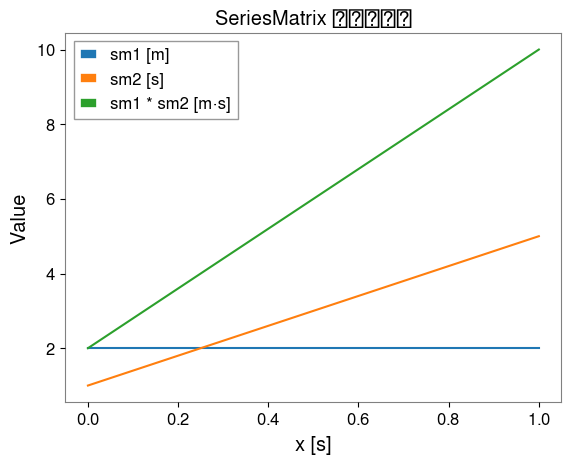

In [3]:
# === 共通の Index を定義 ===
xindex = Index(np.linspace(0, 1, 5), unit="s")

# === テスト対象の SeriesMatrix ===
sm1 = SeriesMatrix(np.full((2, 2, 5), 2) * u.m, xindex=xindex)
sm2 = SeriesMatrix(np.tile(np.linspace(1, 5, 5), (2, 2, 1)) * u.s, xindex=xindex)
print("\nsm1\n", sm1)
print("\nsm2\n", sm2)

# === 検証演算群 ===
print("加算（同次元）:")
try:
    sm_add = sm1 + SeriesMatrix(np.ones((2, 2, 5)) * u.m, xindex=xindex)
    print(" → OK:", sm_add["row0", "col0"].unit)
except Exception as e:
    print(" → 失敗:", e)

print("\n加算（異次元）:")
try:
    sm1 + sm2  # m + s → エラー
except Exception as e:
    print(" → 期待通りのエラー:", type(e), e)

print("\n乗算:")
sm_mul = sm1 * sm2
print(" → 結果のunit:", sm_mul["row0", "col0"].unit)

print("\n除算:")
sm_div = sm1 / sm2
print(" → 結果のunit:", sm_div["row0", "col0"].unit)

print("\n累乗:")
sm_pow = sm1**2
print(" → 結果のunit:", sm_pow["row0", "col0"].unit)

print("\n絶対値:")
sm_abs = abs(-sm1)
print(" → 結果のunit:", sm_abs["row1", "col1"].unit)

# === プロット（任意） ===
fig, ax = plt.subplots()
ax.plot(sm1["row0", "col0"], label="sm1 [m]")
ax.plot(sm2["row0", "col0"], label="sm2 [s]")
ax.plot(sm_mul["row0", "col0"], label="sm1 * sm2 [m·s]")
ax.set_xlabel(f"x [{xindex.unit}]")
ax.set_ylabel("Value")
ax.legend()
plt.title("SeriesMatrix 演算結果例")
plt.grid()
plt.show()

In [4]:
# Quantity(1D)
sm1 = SeriesMatrix(np.linspace(0, 1, 5) * u.m, x0=0, dx=1, xunit="s")
print(sm1.shape, sm1["row0", "col0"].unit)  # (1,1), m

# Series
ix = Index(np.linspace(0, 1, 5), unit="s")
sm2 = SeriesMatrix(Series(np.random.randn(5), xindex=ix, unit="V"))
print(sm2.xindex, sm2["row0", "col0"].unit)

# Array (without xindex): 失敗する例
try:
    sm3 = SeriesMatrix(Array(np.arange(5)))
except ValueError as e:
    print("Expected failure:", e)

(1, 1, 5) m
[0.   0.25 0.5  0.75 1.  ] s V
Expected failure: xindex or (x0, dx) must be specified


In [5]:
data = [
    Series(np.random.randn(5), xindex=Index(np.arange(5), unit="s"), unit="m"),
    Array(np.linspace(0, 1, 5), unit="m"),
    np.pi,
]
sm = SeriesMatrix(data, x0=0, dx=1, xunit="s")
print(sm)
print(sm.shape)  # → (3, 1)
print(sm.xindex)  # → Index from Series
print(sm["row0", "col0"])
print(sm["row2", "col0"])

SeriesMatrix(shape=(3, 1, 5),  name='')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 1.0 s
  xunit   : s
  samples : 5

[ Row metadata ]
     name channel unit
key                   
row0                  
row1                  
row2                  

[ Column metadata ]
     name channel unit
key                   
col0                  

[ Elements metadata ]
  unit      name channel  row  col
0    m      None    None    0    0
1    m      None    None    1    0
2       elem_2_0    None    2    0
(3, 1, 5)
[0. 1. 2. 3. 4.] s
Series([-1.1275701 , -0.19901338,  1.18759863, -1.56672417,
         0.5833525 ]
       unit: m,
       name: None,
       epoch: None,
       channel: None,
       x0: 0.0 s,
       dx: 1.0 s,
       xindex: [0. 1. 2. 3. 4.] s)
Series([3.14159265, 3.14159265, 3.14159265, 3.14159265,
        3.14159265]
       unit: dimensionless,
       name: elem_2_0,
       epoch: None,
       channel: None,
       x0: 0.0 s,
       dx: 1.0 s,
       xindex: [0. 1. 2. 3. 4.]

In [6]:
data2d = [
    [
        Series(np.random.randn(5), xindex=Index(np.arange(5), unit="s"), unit="m"),
        Array(np.ones(5), unit="m"),
        np.pi,
    ],
    [
        Series(np.random.randn(5), xindex=Index(np.arange(5), unit="s"), unit="m"),
        np.zeros(5) * u.N,
        1.0,
    ],
]

sm = SeriesMatrix(data2d, name="a")
print(sm)
print(sm.shape)  # (2, 3)
print(sm.xindex)  # [0. 1. 2. 3. 4.] s
print(sm["row0", "col0"])  # ブロードキャストされた定数配列

SeriesMatrix(shape=(2, 3, 5),  name='a')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 1.0 s
  xunit   : s
  samples : 5

[ Row metadata ]
     name channel unit
key                   
row0                  
row1                  

[ Column metadata ]
     name channel unit
key                   
col0                  
col1                  
col2                  

[ Elements metadata ]
  unit      name channel  row  col
0    m      None    None    0    0
1    m      None    None    0    1
2       elem_0_2    None    0    2
3    m      None    None    1    0
4    N  elem_1_1    None    1    1
5       elem_1_2    None    1    2
(2, 3, 5)
[0. 1. 2. 3. 4.] s
Series([-0.98819163,  0.75143605,  0.58534011, -0.44560855,
         1.14450913]
       unit: m,
       name: None,
       epoch: None,
       channel: None,
       x0: 0.0 s,
       dx: 1.0 s,
       xindex: [0. 1. 2. 3. 4.] s)


In [7]:
data3d = np.random.randn(2, 3, 5) + 1j * np.random.randn(2, 3, 5)
qdata3d = data3d * u.m

sm = SeriesMatrix(qdata3d, x0=0, dx=1, xunit="s")
print(sm)
print(sm.shape)  # (2, 3)
print(sm.xindex)  # Index from 0 to 4
print(sm["row1", "col2"])  # Array with 5 samples, unit=m

SeriesMatrix(shape=(2, 3, 5),  name='')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 1.0 s
  xunit   : s
  samples : 5

[ Row metadata ]
     name channel unit
key                   
row0                  
row1                  

[ Column metadata ]
     name channel unit
key                   
col0                  
col1                  
col2                  

[ Elements metadata ]
  unit  name channel  row  col
0    m  None    None    0    0
1    m  None    None    0    1
2    m  None    None    0    2
3    m  None    None    1    0
4    m  None    None    1    1
5    m  None    None    1    2
(2, 3, 5)
[0. 1. 2. 3. 4.] s
Series([-0.41081928+0.15143439j, -0.78002622-1.17974116j,
         0.69548409-1.08045377j, -2.1994463 +0.07502306j,
        -1.31504065+0.91296566j]
       unit: m,
       name: None,
       epoch: None,
       channel: None,
       x0: 0.0 s,
       dx: 1.0 s,
       xindex: [0. 1. 2. 3. 4.] s)


In [8]:
data3d = np.random.randn(2, 3, 5) + 1j * np.random.randn(2, 3, 5)
qdata3d = data3d * u.m

sm = SeriesMatrix(qdata3d, x0=0, dx=1, xunit="s")
print('sm = SeriesMatrix object(...)"')
print(sm)


sm2 = sm + 3.14 * u.m
print("sm2 = sm + 3.14*u.m")
print(sm2)

sm3 = sm * sm2
print("sm3 = sm * sm2")
print(sm3)

sm4 = np.abs(sm)
print("sm4 = np.abs(sm)")
print(sm4)


sm5 = 5 * sm
print("sm5 = 5*sm")
print(sm5)

sm = SeriesMatrix object(...)"
SeriesMatrix(shape=(2, 3, 5),  name='')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 1.0 s
  xunit   : s
  samples : 5

[ Row metadata ]
     name channel unit
key                   
row0                  
row1                  

[ Column metadata ]
     name channel unit
key                   
col0                  
col1                  
col2                  

[ Elements metadata ]
  unit  name channel  row  col
0    m  None    None    0    0
1    m  None    None    0    1
2    m  None    None    0    2
3    m  None    None    1    0
4    m  None    None    1    1
5    m  None    None    1    2
sm2 = sm + 3.14*u.m
SeriesMatrix(shape=(2, 3, 5),  name='')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 1.0 s
  xunit   : s
  samples : 5

[ Row metadata ]
     name channel unit
key                   
row0                  
row1                  

[ Column metadata ]
     name channel unit
key                   
col0                  
col1                  


In [9]:
print("=== __new__() construction tests ===")

# 1. None → 空行列
sm0 = SeriesMatrix()
print("empty", sm0.shape)

# 2. スカラー
sm1 = SeriesMatrix(1.0 * u.m, x0=0, dx=1, xunit="s")
print("scalar", sm1.shape, sm1[0, 0].unit)

# 3. Quantity(1d)
sm2 = SeriesMatrix(np.arange(5) * u.m, x0=0, dx=1, xunit="s")
print("quantity", sm2.shape, sm2[0, 0].unit)

# 4. Series
ix = Index(np.linspace(0, 1, 5), unit="s")
sm3 = SeriesMatrix(Series(np.random.randn(5), xindex=ix, unit="V"))
print("series", sm3.shape, sm3[0, 0].unit, sm3.xindex.unit)

# 5. 1d-list mixed
sm4 = SeriesMatrix(
    [
        Series(np.random.randn(5), xindex=ix, unit="m"),
        Array(np.arange(5), unit="m"),
        1.23 * u.m,
    ],
    x0=0,
    dx=1,
    xunit="s",
)
print("1d-list", sm4.shape)

# 6. 2d-list
sm5 = SeriesMatrix([[1 * u.Hz, 2 * u.Hz], [3 * u.Hz, 4 * u.Hz]], x0=0, dx=1, xunit="s")
print("2d-list", sm5.shape)

# 7. ndarray-3d
qdata = (np.random.randn(2, 3, 5) + 1j * np.random.randn(2, 3, 5)) * u.m
sm6 = SeriesMatrix(qdata, x0=0, dx=1, xunit="s")
print("ndarray-3d", sm6.shape)

=== __new__() construction tests ===
empty (0, 0, 0)
scalar (1, 1, 1) m
quantity (1, 1, 5) m
series (1, 1, 5) V s
1d-list (3, 1, 5)
2d-list (2, 2, 1)
ndarray-3d (2, 3, 5)


In [10]:
print("=== array_ufunc tests ===")

# 元データ
qdata = np.random.randn(2, 3, 5) * u.m
sm = SeriesMatrix(qdata, x0=0, dx=1, xunit="s")
print("original data\n", sm[0, 0][:3])
print(sm.meta)  # 各MetaData
print(sm.meta.units)  # 単位配列
print(sm.meta.to_dataframe())  # DataFrameでunit列確認

# 加算（Quantity）
sm2 = sm + 3.14 * u.m
print("add scalar\n", sm2[0, 0][:3])
print(sm2.meta)  # 各MetaData
print(sm2.meta.units)  # 単位配列
print(sm2.meta.to_dataframe())  # DataFrameでunit列確認


# 掛け算（self * self）
sm3 = sm * sm2
print("multipl\n", sm3[1, 2][:3])

# 絶対値
sm4 = np.abs(sm + 1j * qdata)
# sm4 = np.abs(1j * sm)
print("abs\n", sm4[0, 0][:3])

# 異常系（shape mismatch）
try:
    sm_bad = SeriesMatrix(np.arange(5) * u.m, x0=0, dx=1, xunit="s")
    sm_fail = sm * sm_bad
except ValueError as e:
    print("Expected shape mismatch:", e)

# 異常系（単位不一致）
try:
    sm_fail2 = sm + 3.14  # ← unitless
except Exception as e:
    print("Expected unit error:", e)

=== array_ufunc tests ===
original data
 Series([ 8.01072754e-04, -6.08327652e-01, -1.10420399e+00]
       unit: m,
       name: None,
       epoch: None,
       channel: None,
       x0: 0.0 s,
       dx: 1.0 s,
       xindex: [0. 1. 2.] s)
  unit  name channel  row  col
0    m  None    None    0    0
1    m  None    None    0    1
2    m  None    None    0    2
3    m  None    None    1    0
4    m  None    None    1    1
5    m  None    None    1    2
[[Unit("m") Unit("m") Unit("m")]
 [Unit("m") Unit("m") Unit("m")]]
  unit  name channel  row  col
0    m  None    None    0    0
1    m  None    None    0    1
2    m  None    None    0    2
3    m  None    None    1    0
4    m  None    None    1    1
5    m  None    None    1    2
add scalar
 Series([3.14080107, 2.53167235, 2.03579601]
       unit: m,
       name: None,
       epoch: None,
       channel: None,
       x0: 0.0 s,
       dx: 1.0 s,
       xindex: [0. 1. 2.] s)
  unit  name channel  row  col
0    m  None    None    0   

In [11]:
print("=== metadata (rows, cols) test ===")

# 構築用データ
data = np.random.randn(2, 3, 5) * u.m

# rows / cols のメタ情報
rows = [{"name": "Fx", "unit": "N"}, {"name": "Fy", "unit": "N"}]
cols = [
    {"name": "x", "unit": "m"},
    {"name": "y", "unit": "m"},
    {"name": "z", "unit": "m"},
]

sm = SeriesMatrix(data, x0=0, dx=1, xunit="s", rows=rows, cols=cols)

# メタデータ確認
print("row keys:", sm.rows.keys())
print("col keys:", sm.cols.keys())

print("row[0]:", sm.rows["row0"])  # Fx
print("col[1]:", sm.cols["col1"])  # y

# pandas形式で出力
print("\nRow meta as DataFrame:")
print(sm.rows.to_dataframe())

print("\nCol meta as DataFrame:")
print(sm.cols.to_dataframe())

sm

=== metadata (rows, cols) test ===
row keys: odict_keys(['row0', 'row1'])
col keys: odict_keys(['col0', 'col1', 'col2'])
row[0]:     name: Fx	    unit: N	 channel: 
col[1]:     name: y	    unit: m	 channel: 

Row meta as DataFrame:
     name unit channel
key                   
row0   Fx    N        
row1   Fy    N        

Col meta as DataFrame:
     name unit channel
key                   
col0    x    m        
col1    y    m        
col2    z    m        


<SeriesMatrix shape=(2, 3, 5) rows=('row0', 'row1') cols=('col0', 'col1', 'col2')>

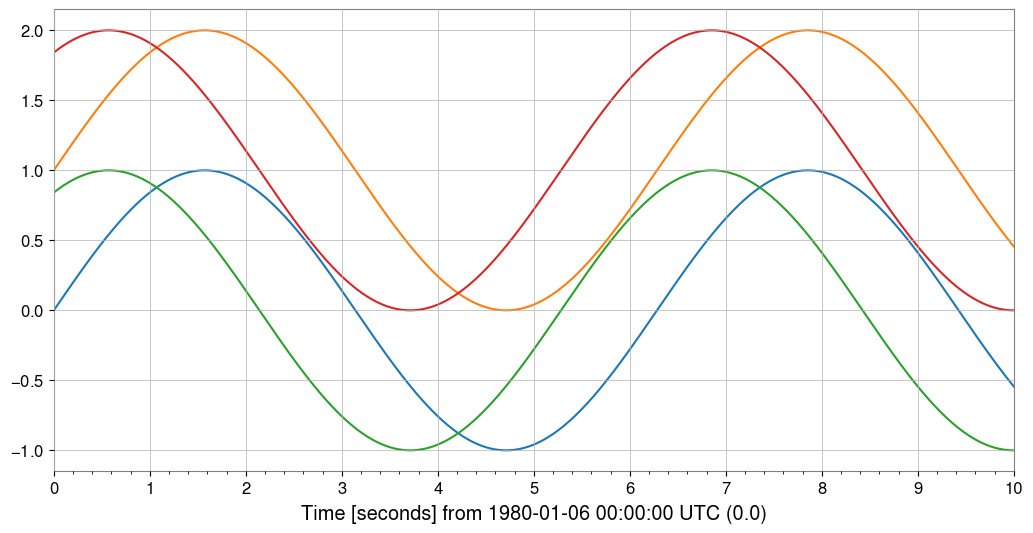

Error in callback <function flush_figures at 0x7f47fbec9da0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [12]:
# テスト用: 2行2列のSeriesMatrixをダミーデータで生成
nrow, ncol, nsample = 2, 2, 1000
t = np.linspace(0, 10, nsample)

# 各セルのMetaData.name用
row_names = {"Fx": {"name": "Fx"}, "Fy": {"name": "Fy"}}
col_names = {"x": {"name": "x"}, "y": {"name": "y"}}

# ダミーデータ生成（例: サイン波, コサイン波, 位相ずらし）
matrix_data = np.zeros((nrow, ncol, nsample))
meta_matrix = np.empty((nrow, ncol), dtype=object)
for i in range(nrow):
    for j in range(ncol):
        matrix_data[i, j] = np.sin(t + i) + j
        # MetaData.nameを物理的意味で設定
        # meta_matrix[i, j] = dict(name=f"{row_names.keys()[i]}→{col_names.keys()[j]}")

# SeriesMatrix生成（MetaDataは実装に応じて適宜調整）
matrix = SeriesMatrix(
    matrix_data,
    xindex=t * u.s,
    rows=row_names,
    cols=col_names,
    meta=meta_matrix,
)

# --- 全パターン描画テスト ---

# (A) 全成分を1つのaxesに重ね描き
matrix.plot(subplots=False)

# (B) 行列状のgrid表示（各セル独立プロット）
matrix.plot(subplots=True)

# (C) 行ごと分割（横に2段, 各段に全列重ね描き）
matrix.plot(subplots="row")

# (D) 列ごと分割（縦に2段, 各段に全行重ね描き）
matrix.plot(subplots="col")

# (E) separate引数による等価指定もOK
matrix.plot(separate="col")  # == subplots='row'
matrix.plot(separate="row")  # == subplots='col'

plt.close()

In [ ]:
xindex = Index(np.arange(0, 5), unit=u.s)  # 0,1,2,3,4 [s]

# 行・列メタデータ
row_meta = MetaDataDict(
    [
        {"name": "X", "unit": u.m, "channel": "IFO:X"},
        {"name": "Y", "unit": u.m, "channel": "IFO:Y"},
    ],
    key_prefix="row",
)
col_meta = MetaDataDict(
    [
        {"name": "Fx", "unit": u.N, "channel": "IFO:Fx"},
        {"name": "Fy", "unit": u.N, "channel": "IFO:Fy"},
    ],
    key_prefix="col",
)

# (行, 列, サンプル数) shape
data1 = np.array(
    [[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]], [[11, 12, 13, 14, 15], [16, 17, 18, 19, 20]]]
)  # shape: (2,2,5)


# SeriesMatrixの生成
sm1 = SeriesMatrix(data=data1, xindex=xindex, rows=row_meta, cols=col_meta)

# コピー・微修正した互換なSeriesMatrixを生成
sm2 = SeriesMatrix(
    data=data1.copy(), xindex=xindex.copy(), rows=row_meta, cols=col_meta
)

# 連続しないxindexのSeriesMatrix
xindex2 = Index(np.arange(5, 10), unit=u.s)
sm3 = SeriesMatrix(data=data1.copy(), xindex=xindex2, rows=row_meta, cols=col_meta)

# ---- is_compatibleの動作試験 ----
assert sm1.is_compatible(sm2) is True  # TrueならOK

try:
    sm1.is_compatible(sm3)
except ValueError as e:
    print(f"互換性チェックエラー: {e}")

# ---- is_contiguousの動作試験 ----
print("連続性 sm1-sm2:", sm1.is_contiguous(sm2))  # -> 0
print(
    "連続性 sm1-sm3:", sm1.is_contiguous(sm3)
)  # -> 1（sm1の末尾とsm3の先頭が一致すれば）

# ---- 境界を明示的に連続させてみる ----
xindex3 = Index(np.arange(4, 9), unit=u.s)
sm4 = SeriesMatrix(data=data1.copy(), xindex=xindex3, rows=row_meta, cols=col_meta)
print("連続性 sm1-sm4:", sm1.is_contiguous(sm4))  # sm1[4]=4, sm4[0]=4 → -1 or 1

# ---- 不整合shapeの場合 ----
row_meta2 = MetaDataDict(
    [{"name": "X", "unit": u.m, "channel": "IFO:X"}], key_prefix="row"
)
try:
    sm5 = SeriesMatrix(data=data1[:, :1], xindex=xindex, rows=row_meta2, cols=col_meta)
    sm1.is_compatible(sm5)
except ValueError as e:
    print(f"shape不一致エラー: {e}")

In [ ]:
row_meta = MetaDataDict(
    [
        {"name": "X", "unit": u.m, "channel": "IFO:X"},
        {"name": "Y", "unit": u.m, "channel": "IFO:Y"},
    ],
    key_prefix="row",
)
col_meta = MetaDataDict(
    [
        {"name": "Fx", "unit": u.N, "channel": "IFO:Fx"},
        {"name": "Fy", "unit": u.N, "channel": "IFO:Fy"},
    ],
    key_prefix="col",
)

# ---- 連続するxindex ----
xindex1 = Index(np.arange(0, 5), unit=u.s)  # 0,1,2,3,4
xindex2 = Index(np.arange(5, 10), unit=u.s)  # 5,6,7,8,9

# ---- gapありxindex ----
xindex3 = Index(np.arange(7, 12), unit=u.s)  # 7,8,9,10,11

# データ shape: (2,2,5)
data_a = np.array(
    [[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]], [[11, 12, 13, 14, 15], [16, 17, 18, 19, 20]]]
)
data_b = np.array(
    [
        [[100, 101, 102, 103, 104], [200, 201, 202, 203, 204]],
        [[300, 301, 302, 303, 304], [400, 401, 402, 403, 404]],
    ]
)
data_c = np.array(
    [
        [[1000, 1001, 1002, 1003, 1004], [2000, 2001, 2002, 2003, 2004]],
        [[3000, 3001, 3002, 3003, 3004], [4000, 4001, 4002, 4003, 4004]],
    ]
)

sm1 = SeriesMatrix(data=data_a, xindex=xindex1, rows=row_meta, cols=col_meta)
sm2 = SeriesMatrix(data=data_b, xindex=xindex2, rows=row_meta, cols=col_meta)
sm3 = SeriesMatrix(data=data_c, xindex=xindex3, rows=row_meta, cols=col_meta)

print("=== 1. append: gapなし（連続）===")
sm12 = sm1.append(sm2)
print(sm12.xindex)
print("値 shape:", sm12.shape)

print("=== 2. append: gapあり/padなし（エラー期待）===")
try:
    sm1.append(sm3)
except ValueError as e:
    print(f"期待通りのエラー: {e}")

print("=== 3. append: gapあり/pad=0（自動NaN→0埋め）===")
sm_gap_pad = sm1.append(sm3, gap=3, pad=0)  # gap=3sまで許容, pad=0
print(sm_gap_pad.xindex)
print("pad部分の値サンプル:", sm_gap_pad.value[:, :, 5:7])  # gap区間

print("=== 4. append: gapあり/pad=nan指定 ===")
sm_gap_nan = sm1.append(sm3, gap=3, pad=np.nan)
print("pad部分nan?:", np.isnan(sm_gap_nan.value[:, :, 5:7]).all())

print("=== 5. prepend: gapあり/pad=999指定 ===")
sm_prep = sm3.prepend(sm1, gap=3, pad=999)
print(sm_prep.xindex)
print("pad部分の値サンプル:", sm_prep.value[:, :, 5:7])

print("=== 6. prepend: gapなし（連続）===")
sm_prep2 = sm2.prepend(sm1)
print(sm_prep2.xindex)

In [ ]:
print("=== append: gapあり（gap=1.0, pad=0）===")
sm12 = sm1.append(sm2, gap=1.0, pad=0)
print(sm12.xindex)
print("値 shape:", sm12.shape)

In [ ]:
# 例：2x2の複素行列＋unit付き
meta = MetaDataMatrix(
    [
        [MetaData(name="A", unit=u.m), MetaData(name="B", unit=u.m)],
        [MetaData(name="C", unit=u.m), MetaData(name="D", unit=u.m)],
    ]
)

n = np.ones(100)
data = np.array([[n + 1j, -n + 1j], [n - 1j, -n - 1j]]) * u.m

sm = SeriesMatrix(data, meta=meta, x0=0, dx=0.1)

print("=== 元の値とunit ===")
for i in range(2):
    for j in range(2):
        print(f"[{i},{j}] value={sm[i, j]}, unit={sm.meta[i, j].unit}")

# 偏角 (ラジアン)
ang = sm.angle()
print("\n=== .angle() 適用後（ラジアン） ===")
for i in range(2):
    for j in range(2):
        print(f"[{i},{j}] angle={ang[i, j]}, unit={ang.meta[i, j].unit}")

# 偏角 (度)
ang_deg = sm.angle(deg=True)
print("\n=== .angle(deg=True) 適用後（度） ===")
for i in range(2):
    for j in range(2):
        print(f"[{i},{j}] angle={ang_deg[i, j]}, unit={ang_deg.meta[i, j].unit}")

In [ ]:
for meta in ang_deg.meta.flat:
    print("Before:", meta["unit"])
    meta["unit"] = u.rad
    print("After:", meta["unit"])